In [1]:
# 20BIT0094 - Pranav Undre
# 20BIT0047 - Rishabh Agrawal
# 20BIT0368 - Neha Elagandula
# Soft computing Image Steganography

# Here we are importing all the libraries required
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [6]:
# Dataset zip file
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Unzipping the contents present in our database
!unzip /content/tiny-imagenet-200.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# Here we are declaring the constants
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SHAPE = (64,64)

In [13]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    # Here we are loading training and test datasets.

    # Arguments used by us in the function are as follows:
        # num_images_per_class_train refers to the number of images per class to load into training dataset.
        # num_images_test refers to the total number of images to load into training dataset.
    
    X_train = []
    X_test = []
    
    # Here we are creating the training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Here we are creating the test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Here we are returning the train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [14]:
# Here we are loading the dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Here we are normalizing the image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Here we are printing the statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) 
# The above statement will result in the output of format (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [15]:
# Here we are splitting training set into two halfs.
# First half is used for training as secret images and second half for cover images.

# S refers to secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C refers to cover image
input_C = X_train[X_train.shape[0] // 2:]

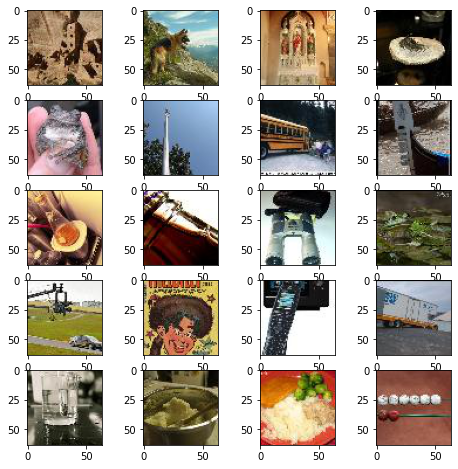

In [16]:
# Here we are displaying sample images from the training dataset.
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # The line below will randomly sample images from training dataset and will be displayed.
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [17]:
# The beta variable declared by below is used to weight the losses of the secret and cover images and its value is set based on the most feasible value 
# proposed in the papers which we encountered during literature review. 
beta = 1.0
    
# The function below will determine loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# The function below will determine loss for the full model, which has been used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# The function below returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # The code below is used for generating Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # The code below is used for generating Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# The function below returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # The variable declared below will store the Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Here we are adding Gaussian noise with 0.01 standard deviation for better training accuracy
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='tanh', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='tanh', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# The function below is for the Full model being used.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [18]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [19]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [20]:
NB_EPOCHS = 60
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Here we are updating the learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 992 of 1000. Loss AE  251682.83 | Loss Rev  120502.89: 100%|██████████| 32/32 [16:36<00:00, 31.15s/it]
Epoch 2 | Batch: 992 of 1000. Loss AE  179168.47 | Loss Rev   64310.09: 100%|██████████| 32/32 [12:34<00:00, 23.59s/it]
Epoch 3 | Batch: 192 of 1000. Loss AE  181050.24 | Loss Rev   66284.23:  22%|██▏       | 7/32 [03:23<12:06, 29.07s/it]


KeyboardInterrupt: 

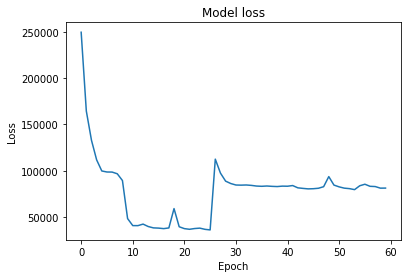

In [ ]:
# Here we are plotting the  loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Here we are retrieving the  decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Here we are evaluating the absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [ ]:
 # The function below calculates mean of Sum of Squared Errors per pixel for cover and secret images.
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

 # The function below calculates histograms of errors for cover and secret image.
def pixel_histogram(diff_S, diff_C):
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=True,  alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=True,  alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
# The code below prints pixel-wise average errors on a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 73.172646
C error per pixel [0, 255]: 92.72131


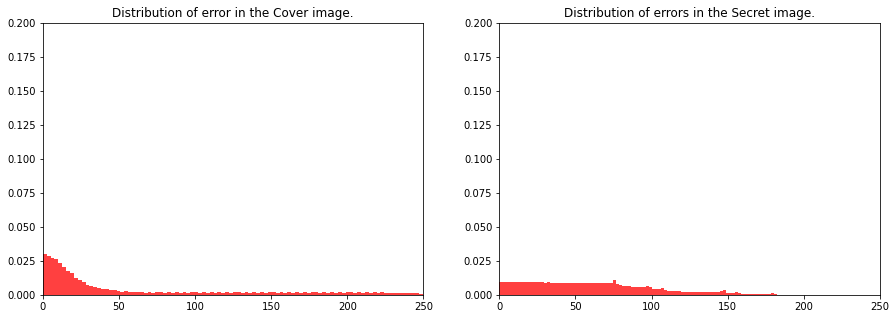

In [ ]:
# Here we are plotting distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM value is 0.7249706379747698
PSNR value is 57.778771985527754 dB
MSE value is 0.32533022816724777
SSIM value is 0.6853665491588302
PSNR value is 57.97070994579716 dB
MSE value is 0.3112652170478809
SSIM value is 0.6125868370464277
PSNR value is 55.291631894645086 dB
MSE value is 0.5768175525002196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM value is 0.5114901347567362
PSNR value is 55.76227153024707 dB
MSE value is 0.5175764130335532
SSIM value is 0.718185592713867
PSNR value is 56.32913410752248 dB
MSE value is 0.45424294067568477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM value is 0.37415127115068253
PSNR value is 56.15860046444992 dB
MSE value is 0.4724344519119794


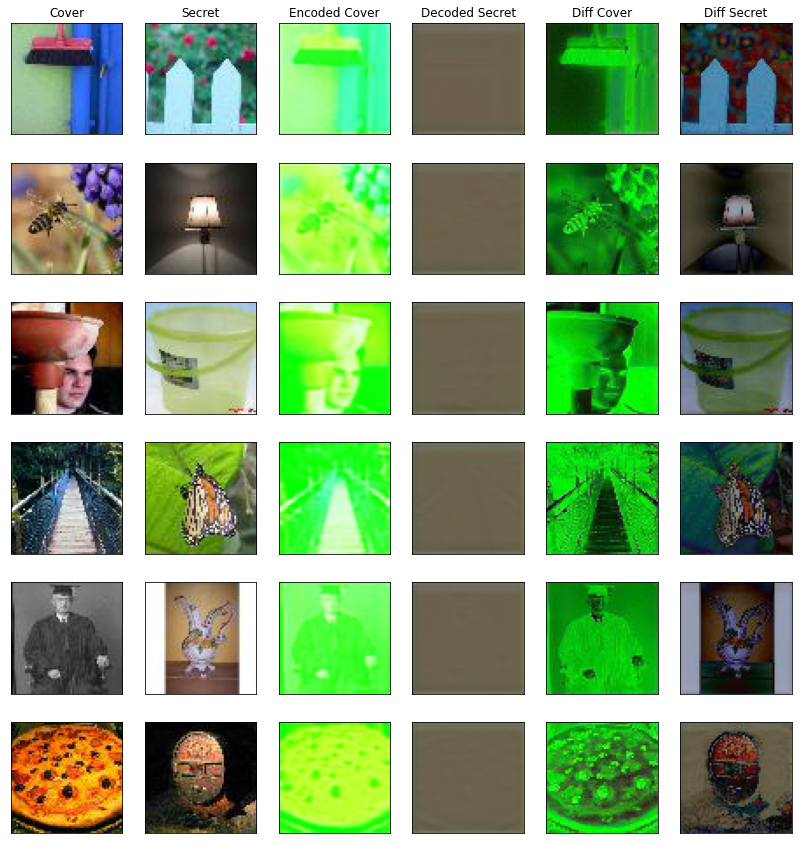

In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim

# Function to evaluate PSNR value
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * np.math.log10(max_pixel / np.math.sqrt(mse))
    return psnr

# Function to evaluate MSE value
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err



# The code below shows images in gray scale
SHOW_GRAY = False
# The code below shows difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Here we have declared Diff enhance magnitude
ENHANCE = 1

# The variable n is declared to show the Number of secret and cover pairs.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    img_np = np.squeeze(input_C[idx])
    img_np1 = np.squeeze(decoded_C[idx])

    kl = ssim(img_np,img_np1,multichannel=True)
    print(f"SSIM value is {kl}")



    original = input_C[idx]
    compressed = decoded_C[idx]
    value = PSNR(original, compressed)
    print(f"PSNR value is {value} dB")

    value1 = mse(original, compressed)
    print(f"MSE value is {value1}")




    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

  
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()